# Imports & Setup

In [34]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

DATA_PATH = '../data/abcd_v1.1.json'
ONTO_PATH = '../data/ontology.json'


# Load Raw Dialogues & Ontology

In [35]:
# Load the dialogues
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    dialogs = json.load(f)

# Load intent/action names
with open(ONTO_PATH, 'r', encoding='utf-8') as f:
    ontology = json.load(f)

# Inspect Structure

In [36]:
# Peek at one dialogue from the training set
from pprint import pprint
print("Available splits:", list(dialogs.keys()))
print("\nFirst dialogue from training set:")
pprint(dialogs['train'][0])  # Access first dialogue from training set

Available splits: ['train', 'dev', 'test']

First dialogue from training set:
{'convo_id': 3592,
 'delexed': [{'candidates': [27949,
                             7582,
                             13567,
                             17765,
                             36101,
                             3654,
                             19384,
                             24610,
                             11279,
                             18856,
                             21389,
                             5960,
                             28378,
                             28236,
                             9549,
                             28427,
                             3660,
                             18433,
                             17370,
                             32708,
                             20048,
                             22386,
                             32336,
                             35202,
                             2178,
         

# Build ID→Name Mappings

In [37]:
# Build Intent and Action Mappings
# For intents, we'll create a flat mapping of all subflows
intent_map = {}
for flow in ontology['intents']['flows']:
    # Add the main flow
    intent_map[flow] = flow.replace('_', ' ').title()
    # Add its subflows
    for subflow in ontology['intents']['subflows'].get(flow, []):
        intent_map[subflow] = subflow.replace('_', ' ').title()

# For actions, we'll create a flat mapping of all action types
action_map = {}
for category, actions in ontology['actions'].items():
    for action_name, params in actions.items():
        action_map[action_name] = action_name.replace('_', ' ').title()

print("Sample Intents:")
for i, (k, v) in enumerate(list(intent_map.items())[:5]):
    print(f"{k}: {v}")
print("\nSample Actions:")
for i, (k, v) in enumerate(list(action_map.items())[:5]):
    print(f"{k}: {v}")

Sample Intents:
account_access: Account Access
recover_username: Recover Username
recover_password: Recover Password
reset_2fa: Reset 2Fa
manage_account: Manage Account

Sample Actions:
verify-identity: Verify-Identity
ask-the-oracle: Ask-The-Oracle
validate-purchase: Validate-Purchase
make-password: Make-Password
promo-code: Promo-Code


# Create Summary DataFrame

In [38]:
# Let's examine the actual structure of a dialogue
print("Example dialogue structure:")
example_dialog = dialogs['train'][0]
print("\nKeys:", list(example_dialog.keys()))
print("\nScenario structure:")
pprint(example_dialog['scenario'])
print("\nFirst few turns of original conversation:")
pprint(example_dialog['original'][:2])
print("\nFirst few turns of delexed conversation:")
pprint(example_dialog['delexed'][:2])

Example dialogue structure:

Keys: ['convo_id', 'scenario', 'original', 'delexed']

Scenario structure:
{'flow': 'product_defect',
 'order': {'city': 'san mateo',
           'full_address': '6821 1st ave  san mateo, ny 75227',
           'num_products': '1',
           'order_id': '3348917502',
           'packaging': 'yes',
           'payment_method': 'credit card',
           'products': "[{'brand': 'michael_kors', 'product_type': 'jeans', "
                       "'amount': 94, 'image_url': "
                       "'images/michael_kors-jeans.jpeg'}]",
           'purchase_date': '2019-11-06',
           'state': 'ny',
           'street_address': '6821 1st ave',
           'zip_code': '75227'},
 'personal': {'customer_name': 'crystal minh',
              'email': 'cminh730@email.com',
              'member_level': 'bronze',
              'phone': '(977) 625-2661',
              'username': 'cminh730'},
 'product': {'amounts': [94], 'names': ['michael_kors jeans']},
 'subflow': 're

In [39]:
# Create Summary DataFrame with the correct structure
rows = []
for split in ['train', 'dev', 'test']:
    for dlg in dialogs[split]:
        try:
            # Basic dialogue info
            dlg_id = dlg['convo_id']
            
            # Get scenario information
            scenario = dlg['scenario']
            flow = scenario.get('flow', 'unknown')  # This is our main intent/flow
            
            # Get conversation turns
            turns = dlg['original']
            n_turns = len(turns)
            
            # Get order details if they exist
            order_info = scenario.get('order', {})
            
            # Get customer details
            personal_info = scenario.get('personal', {})
            
            # Get product details
            product_info = scenario.get('product', {})
            
            rows.append({
                'split': split,
                'dialogue_id': dlg_id,
                'flow': flow,
                'n_turns': n_turns,
                'member_level': personal_info.get('member_level', ''),
                'num_products': order_info.get('num_products', ''),
                'payment_method': order_info.get('payment_method', ''),
                'product_names': ', '.join(product_info.get('names', [])),
                'product_amounts': ', '.join(str(x) for x in product_info.get('amounts', []))
            })
            
            # Print first successful dialogue creation for verification
            if len(rows) == 1:
                print("\nFirst successfully processed dialogue:")
                pprint(rows[0])
                
        except Exception as e:
            print(f"Error processing dialogue in {split}: {str(e)}")
            print("Dialogue content:")
            pprint(dlg)
            break

if rows:
    df = pd.DataFrame(rows)
    print("\nDataFrame head:")
    print(df.head())
    
    # Print some statistics
    print("\nFlow (intent) distribution:")
    print(df['flow'].value_counts())
    
    print("\nNumber of dialogues per split:")
    print(df['split'].value_counts())
    
    print("\nMember level distribution:")
    print(df['member_level'].value_counts())
    
    # Calculate average turns per flow
    print("\nAverage turns per flow:")
    print(df.groupby('flow')['n_turns'].mean().sort_values(ascending=False))
else:
    print("\nNo rows were successfully processed!")


First successfully processed dialogue:
{'dialogue_id': 3592,
 'flow': 'product_defect',
 'member_level': 'bronze',
 'n_turns': 29,
 'num_products': '1',
 'payment_method': 'credit card',
 'product_amounts': '94',
 'product_names': 'michael_kors jeans',
 'split': 'train'}

DataFrame head:
   split  dialogue_id             flow  n_turns member_level num_products  \
0  train         3592   product_defect       29       bronze            1   
1  train         9489   product_defect       21         gold            1   
2  train         3695  storewide_query       22       bronze                
3  train         5798   shipping_issue       23       silver            3   
4  train         3647  storewide_query       23        guest            3   

  payment_method                                      product_names  \
0    credit card                                 michael_kors jeans   
1    credit card                                 michael_kors shirt   
2                                 

# High-Level Stats

Total dialogues: 10042


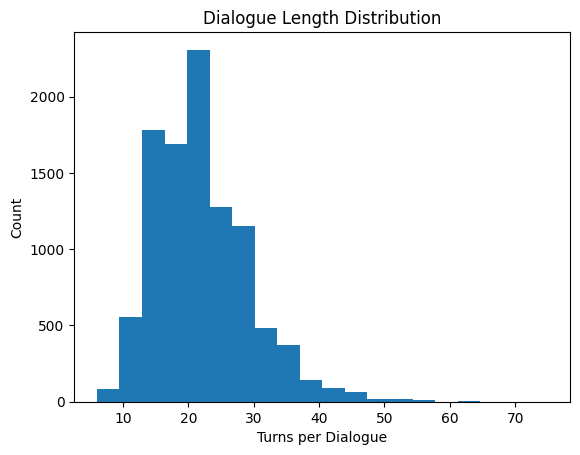

In [40]:
# Number of dialogues
print("Total dialogues:", len(df))

plt.hist(df['n_turns'], bins=20)
plt.xlabel('Turns per Dialogue')
plt.ylabel('Count')
plt.title('Dialogue Length Distribution')
plt.show()


# Plot Top Intents

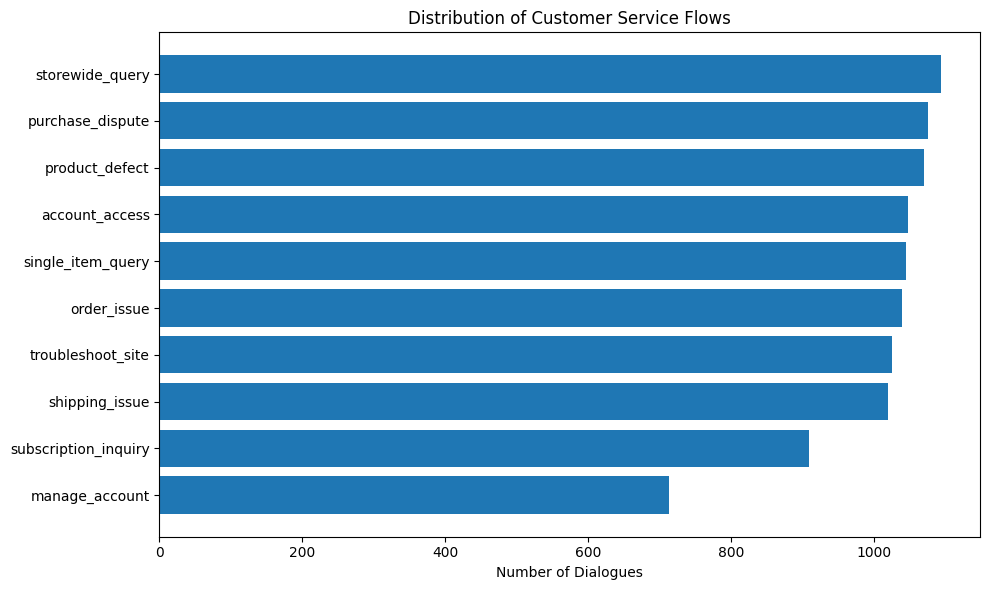

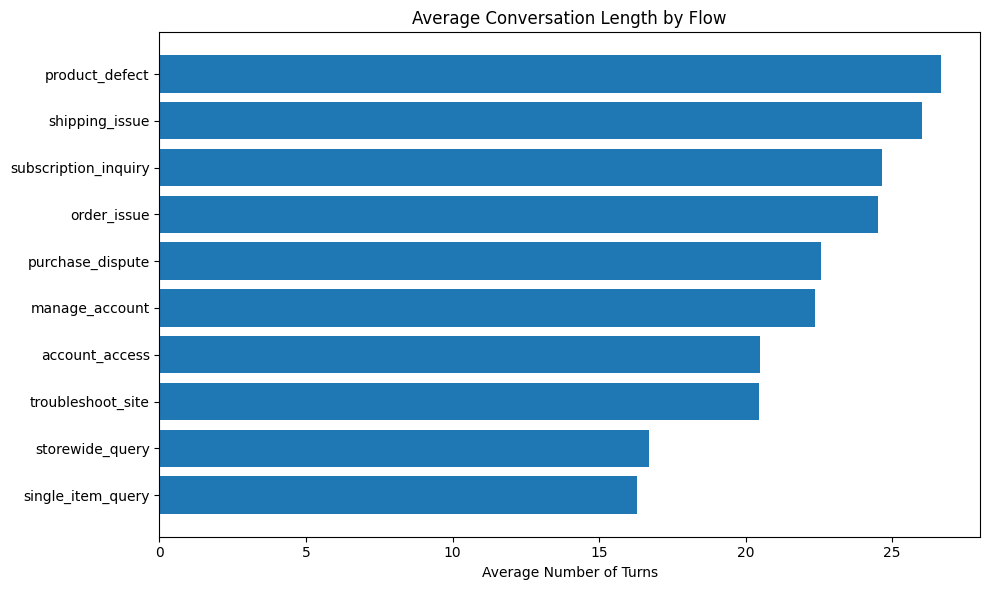

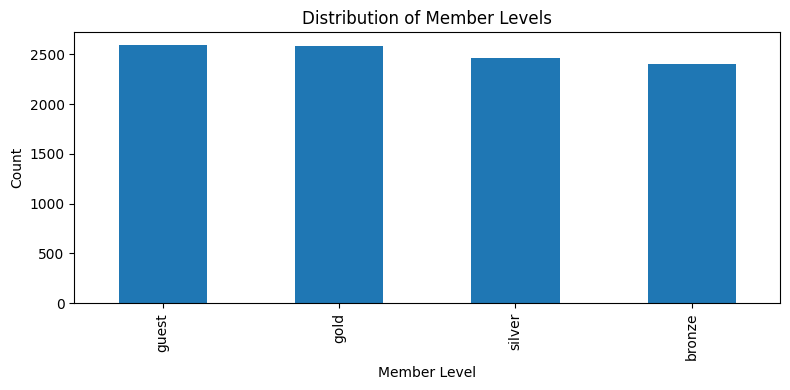


Summary Statistics:
Total number of dialogues: 10042

Average turns by flow:
                       mean  count  min  max
flow                                        
account_access        20.49   1048    9   51
manage_account        22.38    713    9   64
order_issue           24.52   1040    8   56
product_defect        26.67   1070    6   56
purchase_dispute      22.57   1076    8   65
shipping_issue        26.01   1020    9   54
single_item_query     16.29   1045    7   62
storewide_query       16.69   1094    7   55
subscription_inquiry  24.65    910    8   75
troubleshoot_site     20.46   1026    7   63


In [41]:
# Plot top flows/intents
top_flows = df['flow'].value_counts().nlargest(10)
plt.figure(figsize=(10,6))
plt.barh(top_flows.index[::-1], top_flows.values[::-1])
plt.xlabel('Number of Dialogues')
plt.title('Distribution of Customer Service Flows')
plt.tight_layout()
plt.show()

# Let's also show some additional visualizations
# 1. Average conversation length by flow
plt.figure(figsize=(10,6))
avg_turns = df.groupby('flow')['n_turns'].mean().sort_values(ascending=True)
plt.barh(avg_turns.index, avg_turns.values)
plt.xlabel('Average Number of Turns')
plt.title('Average Conversation Length by Flow')
plt.tight_layout()
plt.show()

# 2. Member level distribution
plt.figure(figsize=(8,4))
df['member_level'].value_counts().plot(kind='bar')
plt.title('Distribution of Member Levels')
plt.xlabel('Member Level')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nSummary Statistics:")
print(f"Total number of dialogues: {len(df)}")
print("\nAverage turns by flow:")
print(df.groupby('flow')['n_turns'].agg(['mean', 'count', 'min', 'max']).round(2))

# Top 10 Dialogue Success Rates by Intent

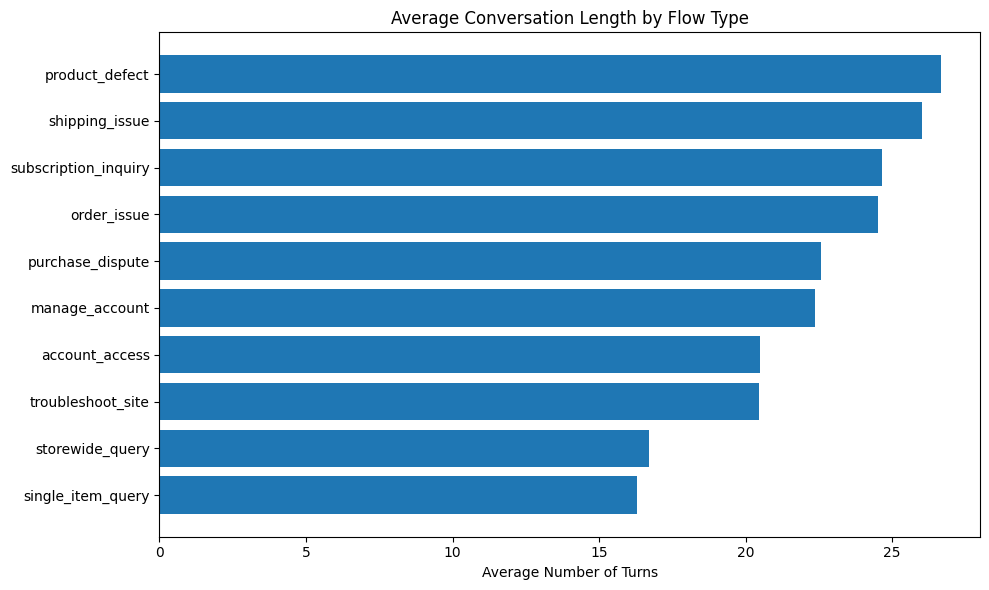

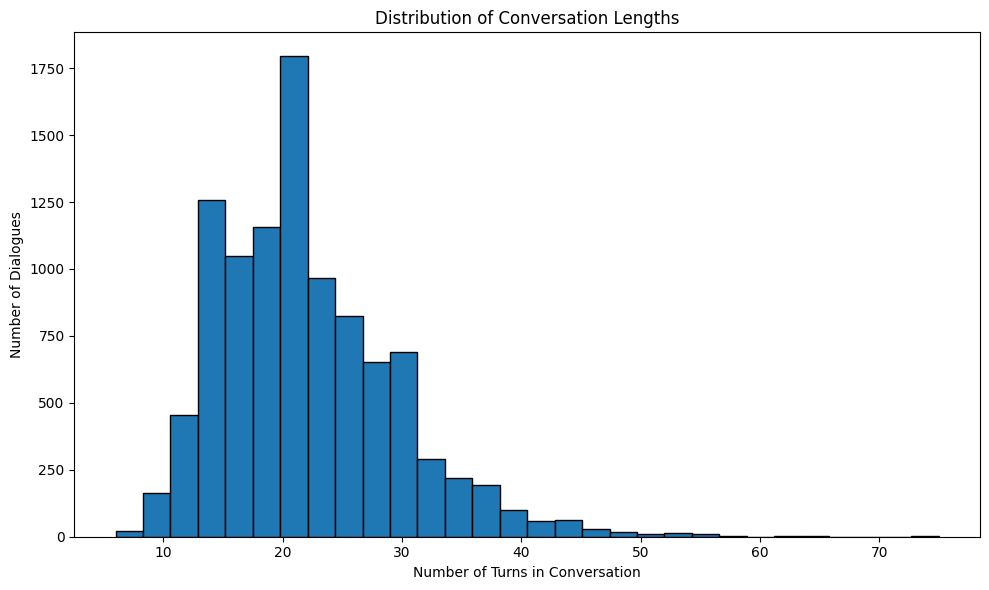

<Figure size 1200x600 with 0 Axes>

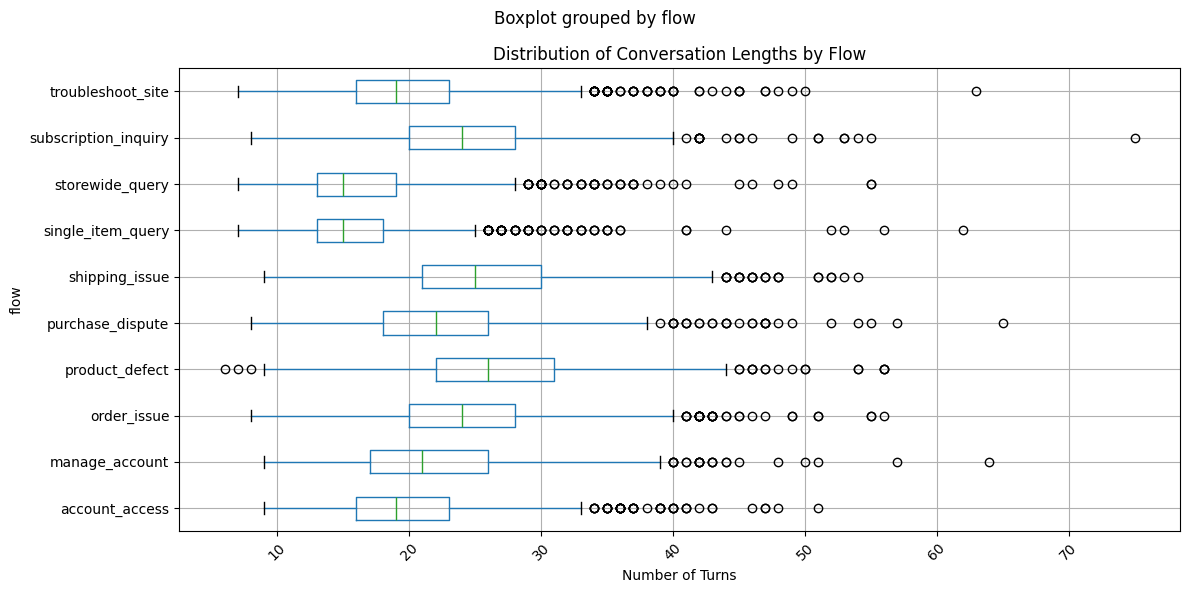


Summary Statistics by Flow:
                      Count  Avg Turns  Std Dev  Min Turns  Max Turns  \
flow                                                                    
storewide_query        1094      16.69     6.02          7         55   
purchase_dispute       1076      22.57     6.74          8         65   
product_defect         1070      26.67     7.20          6         56   
account_access         1048      20.49     6.21          9         51   
single_item_query      1045      16.29     5.66          7         62   
order_issue            1040      24.52     6.49          8         56   
troubleshoot_site      1026      20.46     6.72          7         63   
shipping_issue         1020      26.01     6.72          9         54   
subscription_inquiry    910      24.65     6.56          8         75   
manage_account          713      22.38     6.89          9         64   

                     Most Common Member Level  
flow                                          

In [42]:
# Plot success rates by flow
success_rates = df.groupby('flow')['n_turns'].mean().sort_values(ascending=False).nlargest(10)
plt.figure(figsize=(10,6))
plt.barh(success_rates.index[::-1], success_rates.values[::-1])
plt.xlabel('Average Number of Turns')
plt.title('Average Conversation Length by Flow Type')
plt.tight_layout()
plt.show()

# Let's also look at some other interesting metrics

# 1. Distribution of conversation lengths
plt.figure(figsize=(10,6))
plt.hist(df['n_turns'], bins=30, edgecolor='black')
plt.xlabel('Number of Turns in Conversation')
plt.ylabel('Number of Dialogues')
plt.title('Distribution of Conversation Lengths')
plt.tight_layout()
plt.show()

# 2. Box plot of turns by flow
plt.figure(figsize=(12,6))
df.boxplot(column='n_turns', by='flow', vert=False, figsize=(12,6))
plt.title('Distribution of Conversation Lengths by Flow')
plt.xlabel('Number of Turns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics by Flow:")
summary_stats = df.groupby('flow').agg({
    'n_turns': ['count', 'mean', 'std', 'min', 'max'],
    'member_level': lambda x: x.value_counts().index[0]  # most common member level
}).round(2)

# Rename the columns for better readability
summary_stats.columns = ['Count', 'Avg Turns', 'Std Dev', 'Min Turns', 'Max Turns', 'Most Common Member Level']
print(summary_stats.sort_values('Count', ascending=False))

# Intent/Flow Analysis

In [44]:
print("=== Intent/Flow Analysis ===")
# Create a mapping of flows and their subflows from ontology
with open('../data/ontology.json', 'r', encoding='utf-8') as f:
    ontology = json.load(f)

# Print the structure of flows and subflows
print("\nFlow Structure:")
flows = ontology['intents']['flows']
subflows = ontology['intents']['subflows']
print(f"Number of main flows: {len(flows)}")
for flow in flows:
    print(f"\n{flow}:")
    if flow in subflows:
        for subflow in subflows[flow]:
            print(f"  - {subflow}")

=== Intent/Flow Analysis ===

Flow Structure:
Number of main flows: 10

account_access:
  - recover_username
  - recover_password
  - reset_2fa

manage_account:
  - status_service_added
  - status_service_removed
  - status_shipping_question
  - status_credit_missing
  - manage_change_address
  - manage_change_name
  - manage_change_phone
  - manage_payment_method

order_issue:
  - status_mystery_fee
  - status_delivery_time
  - status_payment_method
  - status_quantity
  - manage_upgrade
  - manage_downgrade
  - manage_create
  - manage_cancel

product_defect:
  - refund_initiate
  - refund_update
  - refund_status
  - return_stain
  - return_color
  - return_size

purchase_dispute:
  - bad_price_competitor
  - bad_price_yesterday
  - out_of_stock_general
  - out_of_stock_one_item
  - promo_code_invalid
  - promo_code_out_of_date
  - mistimed_billing_already_returned
  - mistimed_billing_never_bought

shipping_issue:
  - status
  - manage
  - missing
  - cost

single_item_query:
  - b

# Action Analysis

In [45]:
print("\n=== Action Analysis ===")
actions = ontology['actions']
print("\nAction Categories:")
for category, category_actions in actions.items():
    print(f"\n{category}:")
    print(f"Number of actions: {len(category_actions)}")
    # Print first 3 actions as examples
    for action_name in list(category_actions.keys())[:3]:
        print(f"  - {action_name}")


=== Action Analysis ===

Action Categories:

kb_query:
Number of actions: 6
  - verify-identity
  - ask-the-oracle
  - validate-purchase

interaction:
Number of actions: 10
  - offer-refund
  - make-purchase
  - record-reason

faq_policy:
Number of actions: 14
  - membership
  - search-faq
  - try-again


# structure of a dialogue

In [47]:
print("=== Examining Dialogue Structure ===")
sample_dialog = dialogs['train'][0]
print("\nKeys in dialogue:")
print(list(sample_dialog.keys()))

print("\nFirst few turns:")
turns = sample_dialog['original']
for i, turn in enumerate(turns[:3]):  # Look at first 3 turns
    print(f"\nTurn {i}:")
    print(type(turn))  # Check the type of turn
    print(turn)  # Print the turn content

=== Examining Dialogue Structure ===

Keys in dialogue:
['convo_id', 'scenario', 'original', 'delexed']

First few turns:

Turn 0:
<class 'list'>
['agent', 'Hi!']

Turn 1:
<class 'list'>
['agent', 'How can I help you?']

Turn 2:
<class 'list'>
['customer', 'Hi! I need to return an item, can you help me with that?']


# Dialogue Analysis

In [48]:
print("\n=== Dialogue Analysis ===")
all_turn_counts = []
all_speaker_sequences = []
customer_turn_lengths = []
agent_turn_lengths = []
total_dialogs = 0

for split in ['train', 'dev', 'test']:
    for dialog in dialogs[split]:
        total_dialogs += 1
        turns = dialog['original']
        
        # Count turns
        n_turns = len(turns)
        all_turn_counts.append(n_turns)
        
        # Analyze speakers and turn lengths
        speakers = [turn[0] for turn in turns]  # First element is the speaker
        all_speaker_sequences.append(speakers)
        
        # Analyze turn lengths by speaker
        for turn in turns:
            speaker, text = turn[0], turn[1]
            words = len(text.split())
            if speaker == 'customer':
                customer_turn_lengths.append(words)
            elif speaker == 'agent':
                agent_turn_lengths.append(words)

print(f"\nDataset Statistics:")
print(f"Total number of dialogues: {total_dialogs}")
print(f"Average turns per dialogue: {np.mean(all_turn_counts):.2f}")
print(f"Min turns: {min(all_turn_counts)}")
print(f"Max turns: {max(all_turn_counts)}")


=== Dialogue Analysis ===

Dataset Statistics:
Total number of dialogues: 10042
Average turns per dialogue: 22.01
Min turns: 6
Max turns: 75


# Turn length statistics

In [49]:
print(f"\nTurn Length Statistics:")
print(f"Average customer turn length (words): {np.mean(customer_turn_lengths):.2f}")
print(f"Average agent turn length (words): {np.mean(agent_turn_lengths):.2f}")


Turn Length Statistics:
Average customer turn length (words): 6.17
Average agent turn length (words): 10.06


# Visualize turn distribution

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(all_turn_counts, bins=30, edgecolor='black')
plt.title('Distribution of Dialogue Lengths')
plt.xlabel('Number of Turns')
plt.ylabel('Count')
plt.show()

# # Visualizations

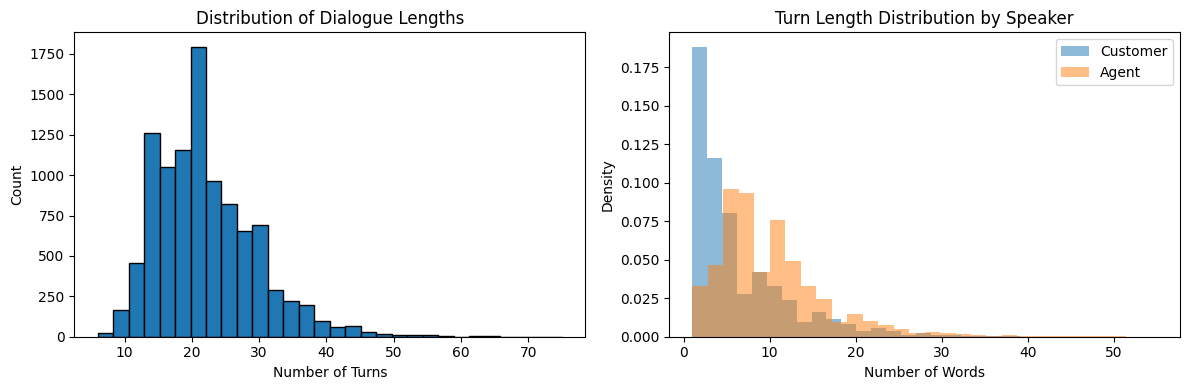

In [50]:
plt.figure(figsize=(12, 4))

# Plot 1: Dialogue Length Distribution
plt.subplot(1, 2, 1)
plt.hist(all_turn_counts, bins=30, edgecolor='black')
plt.title('Distribution of Dialogue Lengths')
plt.xlabel('Number of Turns')
plt.ylabel('Count')

# Plot 2: Turn Length Distribution by Speaker
plt.subplot(1, 2, 2)
plt.hist(customer_turn_lengths, bins=30, alpha=0.5, label='Customer', density=True)
plt.hist(agent_turn_lengths, bins=30, alpha=0.5, label='Agent', density=True)
plt.title('Turn Length Distribution by Speaker')
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# # Analyze Flow Distribution

In [51]:
print("\n=== Flow Distribution ===")
flows = []
for split in dialogs:
    for dialog in dialogs[split]:
        flow = dialog['scenario'].get('flow')
        if flow:
            flows.append(flow)

flow_counts = pd.Series(flows).value_counts()
print("\nTop 10 most common flows:")
print(flow_counts.head(10))


=== Flow Distribution ===

Top 10 most common flows:
storewide_query         1094
purchase_dispute        1076
product_defect          1070
account_access          1048
single_item_query       1045
order_issue             1040
troubleshoot_site       1026
shipping_issue          1020
subscription_inquiry     910
manage_account           713
Name: count, dtype: int64


# Slot and Value Analysis

In [53]:
print("\n=== Slot and Value Analysis ===")
values = ontology['values']
print("\nEnumerable Values:")
for category, values_list in values['enumerable'].items():
    print(f"\n{category}:")
    print(f"Number of possible values: {len(values_list)}")
    print("Example values:", values_list[:3])


=== Slot and Value Analysis ===

Enumerable Values:

account_slotval:
Number of possible values: 4
Example values: ['add service', 'extend subscription', 'remove service']

company_team:
Number of possible values: 3
Example values: ['manager', 'website team', 'purchasing department']

customer_name:
Number of possible values: 10
Example values: ['Alessandro Phoenix', 'Joyce Wu', 'Albert Sanders']

details_slotval:
Number of possible values: 1
Example values: ['troubleshoot']

membership_level:
Number of possible values: 4
Example values: ['guest', 'bronze', 'silver']

change_option:
Number of possible values: 7
Example values: ['change address', 'change date', 'change item']

order_slotval:
Number of possible values: 8
Example values: ['give credit', 'tomorrow', 'next week']

payment_method:
Number of possible values: 3
Example values: ['credit card', 'debit card', 'paypal']

product:
Number of possible values: 16
Example values: ['calvin klein boots', 'calvin klein jacket', 'calvin k

# Plot flow distribution

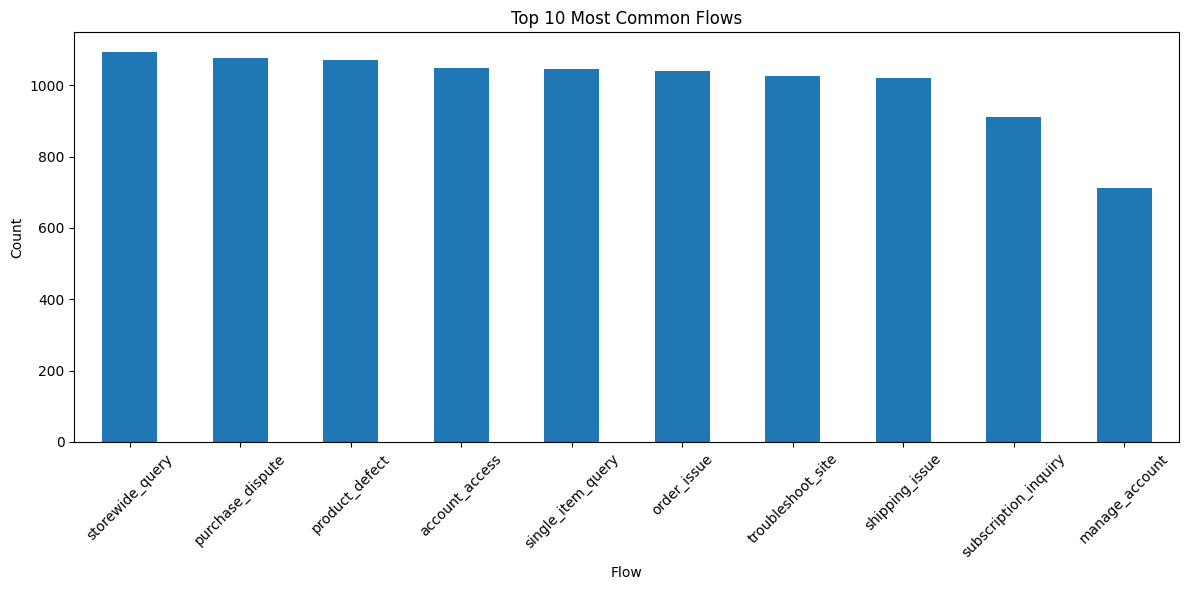

In [54]:
flow_counts = pd.Series([dialog['scenario']['flow'] 
                        for split in dialogs 
                        for dialog in dialogs[split]])
plt.figure(figsize=(12, 6))
flow_counts.value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Most Common Flows')
plt.xlabel('Flow')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sample Dialogue Analysis

In [58]:
print("\n=== Sample Dialogue Analysis ===")
# Take a random dialogue from training set
sample_dialog = random.choice(dialogs['train'])
print("\nSample Dialogue Structure:")
print(f"Flow: {sample_dialog['scenario']['flow']}")
print("\nTurns:")
for i, turn in enumerate(sample_dialog['original'][:5]):  # Show first 5 turns
    print(f"\nTurn {i+1}:")
    print(f"Speaker: {turn[0]}")  # First element is speaker
    print(f"Text: {turn[1][:100]}...")  # Second element is text, show first 100 chars


=== Sample Dialogue Analysis ===

Sample Dialogue Structure:
Flow: product_defect

Turns:

Turn 1:
Speaker: agent
Text: Hi, how can I help you?...

Turn 2:
Speaker: customer
Text: I just received my order in the mail, but it just doesn't fit....

Turn 3:
Speaker: agent
Text: I'm sorry to hear that. Can I please have your name and account number?...

Turn 4:
Speaker: customer
Text: I'm Albert Sanders.  Hold on and I'll look up the account number....

Turn 5:
Speaker: customer
Text: Hm.  I don't see it.  I have a username and an order ID.  Will one of those work?...


# Additional Analysis: Turn-level Statistics

In [59]:
print("\n=== Turn-level Statistics ===")

# Analyze turn lengths
turn_lengths = []
customer_turn_lengths = []
agent_turn_lengths = []

for split in dialogs:
    for dialog in dialogs[split]:
        for turn in dialog['original']:
            speaker, text = turn[0], turn[1]  # Unpack speaker and text
            length = len(text.split())
            turn_lengths.append(length)
            
            if speaker == 'customer':
                customer_turn_lengths.append(length)
            else:
                agent_turn_lengths.append(length)

print(f"\nAverage turn length (words): {np.mean(turn_lengths):.2f}")
print(f"Average customer turn length: {np.mean(customer_turn_lengths):.2f}")
print(f"Average agent turn length: {np.mean(agent_turn_lengths):.2f}")


=== Turn-level Statistics ===

Average turn length (words): 7.91
Average customer turn length: 6.17
Average agent turn length: 9.10


# Visualize turn length distributions

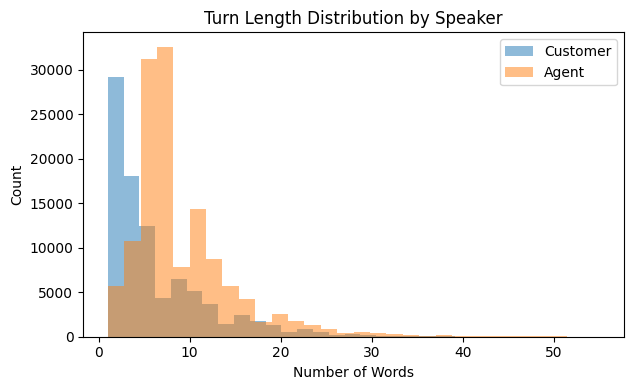

In [60]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(customer_turn_lengths, bins=30, alpha=0.5, label='Customer')
plt.hist(agent_turn_lengths, bins=30, alpha=0.5, label='Agent')
plt.title('Turn Length Distribution by Speaker')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Scenario Analysis

In [61]:
print("\n=== Scenario Analysis ===")

# Collect scenario information
scenario_info = {
    'flows': [],
    'member_levels': [],
    'payment_methods': [],
    'product_types': []
}

for split in dialogs:
    for dialog in dialogs[split]:
        scenario = dialog['scenario']
        
        # Collect flow
        if 'flow' in scenario:
            scenario_info['flows'].append(scenario['flow'])
            
        # Collect personal info
        if 'personal' in scenario and 'member_level' in scenario['personal']:
            scenario_info['member_levels'].append(scenario['personal']['member_level'])
            
        # Collect order info
        if 'order' in scenario:
            if 'payment_method' in scenario['order']:
                scenario_info['payment_methods'].append(scenario['order']['payment_method'])
                
        # Collect product info
        if 'product' in scenario and 'names' in scenario['product']:
            scenario_info['product_types'].extend(scenario['product']['names'])

# Print statistics
print("\nFlow Distribution:")
flow_counts = pd.Series(scenario_info['flows']).value_counts()
print(flow_counts.head())

print("\nMember Level Distribution:")
member_counts = pd.Series(scenario_info['member_levels']).value_counts()
print(member_counts)

print("\nPayment Method Distribution:")
payment_counts = pd.Series(scenario_info['payment_methods']).value_counts()
print(payment_counts)

print("\nTop 10 Product Types:")
product_counts = pd.Series(scenario_info['product_types']).value_counts()
print(product_counts.head(10))


=== Scenario Analysis ===

Flow Distribution:
storewide_query      1094
purchase_dispute     1076
product_defect       1070
account_access       1048
single_item_query    1045
Name: count, dtype: int64

Member Level Distribution:
guest     2592
gold      2586
silver    2462
bronze    2402
Name: count, dtype: int64

Payment Method Distribution:
credit card    432
debit card     410
paypal         398
Name: count, dtype: int64

Top 10 Product Types:
michael_kors jacket     632
calvin_klein jacket     599
michael_kors shirt      597
tommy_hilfiger boots    588
guess jacket            586
guess shirt             584
tommy_hilfiger jeans    583
michael_kors boots      577
calvin_klein boots      576
calvin_klein shirt      571
Name: count, dtype: int64


# Visualize some of these distributions

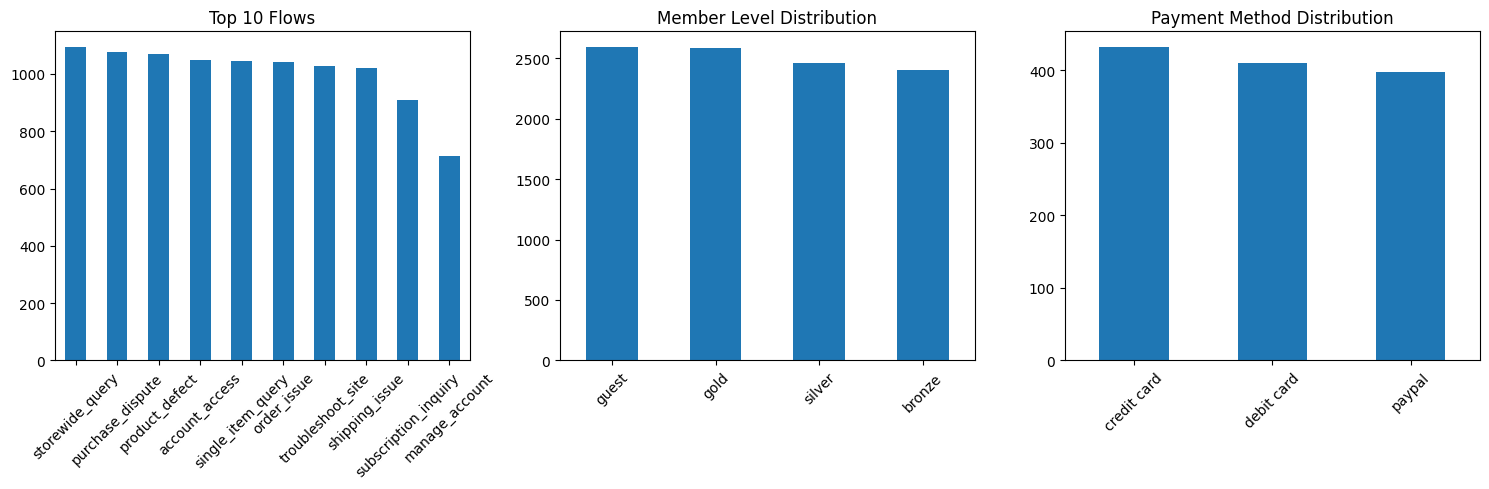

In [62]:
plt.figure(figsize=(15, 5))

# Plot 1: Top Flows
plt.subplot(1, 3, 1)
flow_counts.head(10).plot(kind='bar')
plt.title('Top 10 Flows')
plt.xticks(rotation=45)

# Plot 2: Member Levels
plt.subplot(1, 3, 2)
member_counts.plot(kind='bar')
plt.title('Member Level Distribution')
plt.xticks(rotation=45)

# Plot 3: Payment Methods
plt.subplot(1, 3, 3)
payment_counts.plot(kind='bar')
plt.title('Payment Method Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()